In [14]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, AveragePooling2D, Flatten, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [15]:
train_path = '/kaggle/input/tiny-dataset-imagent/tiny-imagenet-200/train'
val_path = '/kaggle/input/tiny-dataset-imagent/tiny-imagenet-200/val'
test_path = '/kaggle/input/tiny-dataset-imagent/tiny-imagenet-200/test'

print(os.listdir(train_path))

['n02437312', 'n03976657', 'n07753592', 'n02769748', 'n02730930', 'n04465501', 'n02950826', 'n02002724', 'n04532106', 'n02793495', 'n02999410', 'n09332890', 'n03854065', 'n04399382', 'n02056570', 'n04398044', 'n04540053', 'n02058221', 'n04023962', 'n03400231', 'n03838899', 'n04265275', 'n02802426', 'n04149813', 'n02917067', 'n01950731', 'n03085013', 'n04487081', 'n03992509', 'n02279972', 'n07873807', 'n07875152', 'n03599486', 'n04259630', 'n07715103', 'n04501370', 'n09428293', 'n04254777', 'n03770439', 'n03649909', 'n07614500', 'n01882714', 'n01698640', 'n04328186', 'n02699494', 'n02963159', 'n01641577', 'n07747607', 'n03983396', 'n02395406', 'n01774750', 'n03026506', 'n03160309', 'n01855672', 'n03662601', 'n04251144', 'n03255030', 'n02666196', 'n02988304', 'n04275548', 'n03670208', 'n01768244', 'n02132136', 'n07583066', 'n01944390', 'n03388043', 'n02085620', 'n03617480', 'n02795169', 'n04074963', 'n02364673', 'n02823428', 'n02841315', 'n01983481', 'n04596742', 'n07734744', 'n04371430'

In [16]:
def process_image_file(file_path, label, img_size=(64, 64)):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img, label

def load_dataset(dataset_path, label_to_index, split='train', img_size=(64, 64)):
    images, labels = [], []

    if split == 'train':
        for label in label_to_index.keys():
            pattern = os.path.join(dataset_path, label, 'images/*.JPEG')
            for file_path in tf.io.gfile.glob(pattern):
                img, lbl = process_image_file(file_path, label_to_index[label], img_size)
                images.append(img)
                labels.append(lbl)
    elif split == 'val':
        val_annotations_path = os.path.join(dataset_path, 'val_annotations.txt')
        img_label_map = {}
        with open(val_annotations_path, 'r') as f:
            for line in f:
                img_file, label = line.strip().split('\t')[:2]
                if label in label_to_index:
                    img_label_map[img_file] = label_to_index[label]

        images_dir = os.path.join(dataset_path, 'images')
        for img_file, label_idx in img_label_map.items():
            file_path = os.path.join(images_dir, img_file)
            img, lbl = process_image_file(file_path, label_idx, img_size)
            images.append(img)
            labels.append(lbl)

    images = tf.stack(images)
    labels = tf.stack(labels)

    return tf.data.Dataset.from_tensor_slices((images, labels))

num_classes=200

def one_hot_encode(image,label):
    return image, tf.one_hot(label, depth=num_classes)


class_dirs = os.listdir(train_path)
selected_classes = ['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 
                    'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750']
label_to_index = {label: idx for idx, label in enumerate(class_dirs) if label in selected_classes}

train_dataset = load_dataset(train_path, label_to_index, 'train').shuffle(1000).map(lambda x, y: (x, y))
val_dataset = load_dataset(val_path, label_to_index, 'val').map(lambda x, y: (x, y))

train_dataset = train_dataset.map(one_hot_encode)
val_dataset = val_dataset.map(one_hot_encode)

for image, label in train_dataset.take(1):
    print("Shape of image:", image.shape)
    print("Shape of label:", label)

Shape of image: (64, 64, 3)
Shape of label: tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.], shape=(200,), dtype=float32)


In [17]:
def inception_module(input_tensor, filter_channels):
    # 1x1 conv (path 1)
    path1 = Conv2D(filter_channels['1x1'], (1, 1), padding='same', activation='relu')(input_tensor)

    # 1x1 conv -> 3x3 conv (path 2)
    path2 = Conv2D(filter_channels['3x3_reduce'], (1, 1), padding='same', activation='relu')(input_tensor)
    path2 = Conv2D(filter_channels['3x3'], (3, 3), padding='same', activation='relu')(path2)

    # 1x1 conv -> 5x5 conv (path 3)
    path3 = Conv2D(filter_channels['5x5_reduce'], (1, 1), padding='same', activation='relu')(input_tensor)
    path3 = Conv2D(filter_channels['5x5'], (5, 5), padding='same', activation='relu')(path3)

    # 3x3 maxpool -> 1x1 conv (path 4)
    path4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_tensor)
    path4 = Conv2D(filter_channels['pool_proj'], (1, 1), padding='same', activation='relu')(path4)

    # Concatenate filters, assumes filters are concatenated along the third axis
    return concatenate([path1, path2, path3, path4], axis=-1)


def create_googlenet(input_shape=(64, 64, 3), num_classes=1):
    input_tensor = Input(shape=input_shape)


    # Stage 1
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_tensor)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(192, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Stage 2: Inception 3a -> Inception 3b
    x = inception_module(x, {'1x1': 64, '3x3_reduce': 96, '3x3': 128, '5x5_reduce': 16, '5x5': 32, 'pool_proj': 32})
    x = inception_module(x, {'1x1': 128, '3x3_reduce': 128, '3x3': 192, '5x5_reduce': 32, '5x5': 96, 'pool_proj': 64})
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Stage 3: Inception 4a -> Inception 4b -> Inception 4c -> Inception 4d -> Inception 4e
    x = inception_module(x, {'1x1': 192, '3x3_reduce': 96, '3x3': 208, '5x5_reduce': 16, '5x5': 48, 'pool_proj': 64})
    x = inception_module(x, {'1x1': 160, '3x3_reduce': 112, '3x3': 224, '5x5_reduce': 24, '5x5': 64, 'pool_proj': 64})
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Stage 4: Inception 5a -> Inception 5b
    x = inception_module(x, {
    '1x1': 384,
    '3x3_reduce': 192,
    '3x3': 384,
    '5x5_reduce': 48,
    '5x5': 128,
    'pool_proj': 128
})

    #  Use Global Average Pooling to handle variable input sizes
    x = GlobalAveragePooling2D()(x)

    # Dropout
    x = Dropout(0.4)(x)

    # Final layers
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(input_tensor, x, name='googlenet')

    return model

In [18]:
# Assuming train_dataset and val_dataset are defined and batched as shown earlier in the discussion

# Set environment variables and suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  
import tensorflow as tf
tf.get_logger().setLevel('ERROR')  
import warnings
warnings.filterwarnings('ignore', category=UserWarning)


batch_size = 32

# Prepare the training dataset
train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Prepare the validation dataset
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


# Set the number of classes for the dataset
num_classes = 200
k=5
# Create and compile the GoogLeNet model with adjusted classes
googlenet_model = create_googlenet(input_shape=(64, 64, 3), num_classes=num_classes)
googlenet_model.compile(optimizer='adam',  
                        loss='categorical_crossentropy',
                        metrics=['accuracy', TopKCategoricalAccuracy(k=k)])

# Set up callbacks
checkpoint = ModelCheckpoint('googlenet_weights.keras', monitor='val_loss', save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs')

# Train the model using the custom dataset objects
history = googlenet_model.fit(
    train_dataset,
    epochs=120,
    validation_data=val_dataset,
    callbacks=[checkpoint, tensorboard]
)


Epoch 1/120
  1/157 ━━━━━━━━━━━━━━━━━━━━ 47:34 18s/step - accuracy: 0.0000e+00 - loss: 21.9082 - top_k_categorical_accuracy: 0.0000e+00

W0000 00:00:1711476184.584454      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.2212 - loss: 3.6023 - top_k_categorical_accuracy: 0.7969

W0000 00:00:1711476196.409228      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711476198.574450      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711476200.276474      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 101ms/step - accuracy: 0.2215 - loss: 3.5950 - top_k_categorical_accuracy: 0.7969 - val_accuracy: 0.2420 - val_loss: 2.5180 - val_top_k_categorical_accuracy: 0.5780
Epoch 2/120
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.2229 - loss: 2.0549 - top_k_categorical_accuracy: 0.7696 - val_accuracy: 0.2280 - val_loss: 2.4496 - val_top_k_categorical_accuracy: 0.6400
Epoch 3/120
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.2745 - loss: 1.8789 - top_k_categorical_accuracy: 0.8243 - val_accuracy: 0.2380 - val_loss: 2.2987 - val_top_k_categorical_accuracy: 0.6300
Epoch 4/120
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2697 - loss: 1.8807 - top_k_categorical_accuracy: 0.8212 - val_accuracy: 0.2360 - val_loss: 2.4573 - val_top_k_categorical_accuracy: 0.6580
Epoch 5/120
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2762 - loss: 1.9577 - top_k_categorical_accuracy: 0.8159 - val_accuracy: 0.2660 - val_loss: 2.3031 - val_top_k

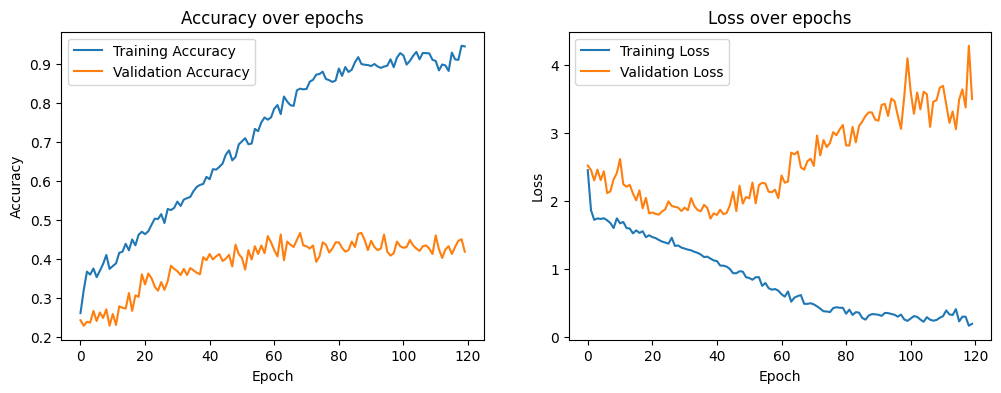

In [19]:

# Visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
from tensorflow.keras.metrics import TopKCategoricalAccuracy


googlenet_results = googlenet_model.evaluate(val_dataset)

print("GoogLeNet Loss:", googlenet_results[0])
print("GoogLeNet Top-1 Accuracy:", googlenet_results[1])
print(f"GoogLeNet Top-{k} Accuracy:", googlenet_results[2])
print(f"GoogLeNet Top-{k} Error:", 1 - googlenet_results[2])

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3583 - loss: 4.1194 - top_k_categorical_accuracy: 0.7890

W0000 00:00:1711476456.308548      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.3847 - loss: 3.8368 - top_k_categorical_accuracy: 0.8204
GoogLeNet Loss: 3.495022773742676
GoogLeNet Top-1 Accuracy: 0.4180000126361847
GoogLeNet Top-5 Accuracy: 0.8519999980926514
GoogLeNet Top-5 Error: 0.14800000190734863


W0000 00:00:1711476457.547631      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
